In [3]:
!kaggle competitions download -c titanic


  0%|          | 0.00/34.1k [00:00<?, ?B/s]
100%|##########| 34.1k/34.1k [00:00<00:00, 2.69MB/s]


In [1]:
import zipfile
with zipfile.ZipFile('./titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, losses
from keras.layers import Dense, Dropout, Input

In [305]:
train_df = pd.read_csv('train.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [306]:
test_X = pd.read_csv('test.csv')
test_X.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [307]:
len(test_X)

418

In [308]:
submission_df = pd.read_csv('gender_submission.csv')
submission_df.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Preprocessing

In [309]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [310]:
for column in train_df.columns:
    print(column,len(train_df[column].unique()))

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 89
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 148
Embarked 4


In [311]:
train_X = train_df.drop('Survived', axis=1)
train_Y = train_df['Survived']

In [312]:
train_size = len(train_X)

In [325]:
merged_df = pd.concat([train_X, test_X])
merged_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [329]:
def preprocessing_df(df):
    df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    df['Cabin'].fillna('N/A', inplace=True)

    df['Age'].fillna(df['Age'].mean(), inplace=True)
    
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    return df
    

In [330]:
merged_df = preprocessing_df(merged_df)

In [331]:
merged_df.info()
merged_df.head(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Sex       1309 non-null   object 
 2   Age       1309 non-null   float64
 3   SibSp     1309 non-null   int64  
 4   Parch     1309 non-null   int64  
 5   Fare      1309 non-null   float64
 6   Cabin     1309 non-null   object 
 7   Embarked  1309 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ KB


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,N/A,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,N/A,S
3,1,female,35.0,1,0,53.1000,C123,S


In [332]:
def EDA(df):
    #df['Cabin'] = df['Cabin'].apply(lambda cabin : 'cabin' if cabin=='N/A' else 'not cabin')
    df.drop(['Cabin'], axis=1, inplace=True)
    df['Family'] = df.apply(lambda row : 'single' if row['SibSp'] + row['Parch'] == 0 
                            else ('medium' if row['SibSp'] + row['Parch'] < 4 else 'large'), axis=1)
    
#     def trans_age(x):
#         if(x<1): x = int(str(x).split('.')[1])
#         if(x<20): return 'young'
#         if(x<60): return 'adult'
#         return 'old'

#     df['Age'] = df['Age'].apply(trans_age)
#     df['Fare'] = df['Fare'].apply(lambda x : 'low' if x<df['Fare'].quantile(0.25) else('medium' if x<df['Fare'].quantile(0.5) 
#                                                                                    else ('high' if x<df['Fare'].quantile(0.75) 
#                                                                                          else 'very high')))
    
    df = df.drop(['SibSp', 'Parch'], axis=1)
    
    return df

In [333]:
merged_df = EDA(merged_df)

In [334]:
merged_df

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,male,22.000000,7.2500,S,medium
1,1,female,38.000000,71.2833,C,medium
2,3,female,26.000000,7.9250,S,single
3,1,female,35.000000,53.1000,S,medium
4,3,male,35.000000,8.0500,S,single
...,...,...,...,...,...,...
413,3,male,29.881138,8.0500,S,single
414,1,female,39.000000,108.9000,C,single
415,3,male,38.500000,7.2500,S,single
416,3,male,29.881138,8.0500,S,single


In [335]:
merged_df = pd.get_dummies(merged_df)
merged_df

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Family_large,Family_medium,Family_single
0,3,22.000000,7.2500,0,1,0,0,1,0,1,0
1,1,38.000000,71.2833,1,0,1,0,0,0,1,0
2,3,26.000000,7.9250,1,0,0,0,1,0,0,1
3,1,35.000000,53.1000,1,0,0,0,1,0,1,0
4,3,35.000000,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
413,3,29.881138,8.0500,0,1,0,0,1,0,0,1
414,1,39.000000,108.9000,1,0,1,0,0,0,0,1
415,3,38.500000,7.2500,0,1,0,0,1,0,0,1
416,3,29.881138,8.0500,0,1,0,0,1,0,0,1


In [235]:
#merged_df.drop(['Sex_female'], axis=1, inplace=True)

In [336]:
scaler = StandardScaler()
merged_df[['Age', 'Fare']] = scaler.fit_transform(merged_df[['Age', 'Fare']])

In [337]:
train_X = merged_df[:train_size]
test_X = merged_df[train_size:]
test_X.fillna(test_X['Fare'].mode(), inplace=True)

In [339]:
pd.merge(pd.DataFrame(train_X),
         train_Y,
         right_index=True, left_index=True).corr()['Survived']

Pclass          -0.338481
Age             -0.070323
Fare             0.257307
Sex_female       0.543351
Sex_male        -0.543351
Embarked_C       0.168240
Embarked_Q       0.003650
Embarked_S      -0.149683
Family_large    -0.125147
Family_medium    0.279855
Family_single   -0.203367
Survived         1.000000
Name: Survived, dtype: float64

In [342]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    train_X, train_Y, test_size=0.3, random_state=42)

In [343]:
features = train_X.shape[1]

In [344]:
def get_model():
    inputs = Input(shape=(features))
    
    x = Dense(256, activation='relu', kernel_initializer = "he_normal")(inputs)
    x = Dense(128, activation='relu', kernel_initializer = "he_normal")(x)
    x = Dense(64, activation='relu', kernel_initializer = "he_normal")(x)
    outputs= Dense(1, activation='sigmoid', kernel_initializer = "he_normal")(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)

In [345]:
model = get_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_8 (Dense)             (None, 256)               3072      
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 44,289
Trainable params: 44,289
Non-trainable params: 0
_________________________________________________________________


In [346]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [347]:
epochs = 1000
batch_size = 20
validation_split = 0.3

In [348]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test,Y_test))

Epoch 1/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.4855 - accuracy: 0.7897 - val_loss: 0.4662 - val_accuracy: 0.8134
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4397 - accuracy: 0.8106 - val_loss: 0.4648 - val_accuracy: 0.8097
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4474 - accuracy: 0.8218 - val_loss: 0.4405 - val_accuracy: 0.8060
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.8266 - val_loss: 0.4368 - val_accuracy: 0.7948
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4017 - accuracy: 0.8315 - val_loss: 0.4367 - val_accuracy: 0.8022
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.4015 - accuracy: 0.8347 - val_loss: 0.4600 - val_accuracy: 0.7910
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3985 - accuracy: 0.8299 - val_loss: 0.4508 - val_accuracy: 0.7985
Epoch 

32/32 [==============================] - 0s 2ms/step - loss: 0.3096 - accuracy: 0.8748 - val_loss: 0.5748 - val_accuracy: 0.7985
Epoch 59/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3070 - accuracy: 0.8716 - val_loss: 0.5565 - val_accuracy: 0.7985
Epoch 60/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8716 - val_loss: 0.5712 - val_accuracy: 0.7985
Epoch 61/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.8604 - val_loss: 0.5718 - val_accuracy: 0.7985
Epoch 62/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8668 - val_loss: 0.5879 - val_accuracy: 0.8060
Epoch 63/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.8732 - val_loss: 0.5950 - val_accuracy: 0.7910
Epoch 64/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2958 - accuracy: 0.8700 - val_loss: 0.6289 - val_accuracy: 0.8022
Epoch 65/1000

32/32 [==============================] - 0s 2ms/step - loss: 0.2864 - accuracy: 0.8684 - val_loss: 0.7757 - val_accuracy: 0.8022
Epoch 116/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.8796 - val_loss: 0.7849 - val_accuracy: 0.7985
Epoch 117/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2986 - accuracy: 0.8700 - val_loss: 0.7660 - val_accuracy: 0.7873
Epoch 118/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2797 - accuracy: 0.8780 - val_loss: 0.7872 - val_accuracy: 0.7910
Epoch 119/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2747 - accuracy: 0.8828 - val_loss: 0.7986 - val_accuracy: 0.7985
Epoch 120/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2721 - accuracy: 0.8892 - val_loss: 0.7860 - val_accuracy: 0.7985
Epoch 121/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2679 - accuracy: 0.8844 - val_loss: 0.8291 - val_accuracy: 0.7910
Epoch 1

Epoch 172/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2455 - accuracy: 0.8892 - val_loss: 0.9133 - val_accuracy: 0.7799
Epoch 173/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2431 - accuracy: 0.8892 - val_loss: 0.9600 - val_accuracy: 0.7985
Epoch 174/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2451 - accuracy: 0.8941 - val_loss: 0.9442 - val_accuracy: 0.7873
Epoch 175/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2488 - accuracy: 0.8957 - val_loss: 1.0197 - val_accuracy: 0.7873
Epoch 176/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2437 - accuracy: 0.8892 - val_loss: 0.9920 - val_accuracy: 0.7948
Epoch 177/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.8925 - val_loss: 0.9248 - val_accuracy: 0.8022
Epoch 178/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2491 - accuracy: 0.8957 - val_loss: 0.9593 - val_accuracy:

Epoch 229/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2977 - accuracy: 0.8909 - val_loss: 1.0638 - val_accuracy: 0.7873
Epoch 230/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.9101 - val_loss: 1.0681 - val_accuracy: 0.7910
Epoch 231/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2421 - accuracy: 0.8989 - val_loss: 1.0011 - val_accuracy: 0.7948
Epoch 232/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2243 - accuracy: 0.9053 - val_loss: 1.0550 - val_accuracy: 0.7873
Epoch 233/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2243 - accuracy: 0.9021 - val_loss: 1.0583 - val_accuracy: 0.7873
Epoch 234/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2189 - accuracy: 0.9069 - val_loss: 1.0814 - val_accuracy: 0.7873
Epoch 235/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.8973 - val_loss: 1.0907 - val_accuracy:

Epoch 286/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2106 - accuracy: 0.9133 - val_loss: 1.1710 - val_accuracy: 0.7910
Epoch 287/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.9053 - val_loss: 1.1412 - val_accuracy: 0.7799
Epoch 288/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.9053 - val_loss: 1.1887 - val_accuracy: 0.7873
Epoch 289/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2261 - accuracy: 0.8957 - val_loss: 1.1271 - val_accuracy: 0.7873
Epoch 290/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2217 - accuracy: 0.9005 - val_loss: 1.2427 - val_accuracy: 0.7799
Epoch 291/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2251 - accuracy: 0.8925 - val_loss: 1.1888 - val_accuracy: 0.7836
Epoch 292/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2147 - accuracy: 0.9117 - val_loss: 1.1810 - val_accuracy:

Epoch 343/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2020 - accuracy: 0.9149 - val_loss: 1.3526 - val_accuracy: 0.7761
Epoch 344/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1979 - accuracy: 0.9149 - val_loss: 1.3824 - val_accuracy: 0.7687
Epoch 345/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1953 - accuracy: 0.9085 - val_loss: 1.4018 - val_accuracy: 0.7873
Epoch 346/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.8973 - val_loss: 1.3405 - val_accuracy: 0.7873
Epoch 347/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9021 - val_loss: 1.3386 - val_accuracy: 0.7873
Epoch 348/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2177 - accuracy: 0.8989 - val_loss: 1.2673 - val_accuracy: 0.7836
Epoch 349/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.2164 - accuracy: 0.8989 - val_loss: 1.3171 - val_accuracy:

Epoch 400/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1844 - accuracy: 0.9181 - val_loss: 1.4901 - val_accuracy: 0.7799
Epoch 401/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1844 - accuracy: 0.9181 - val_loss: 1.4941 - val_accuracy: 0.7687
Epoch 402/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1899 - accuracy: 0.9117 - val_loss: 1.5099 - val_accuracy: 0.7799
Epoch 403/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1797 - accuracy: 0.9246 - val_loss: 1.5812 - val_accuracy: 0.7799
Epoch 404/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.9149 - val_loss: 1.5249 - val_accuracy: 0.7799
Epoch 405/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9165 - val_loss: 1.5490 - val_accuracy: 0.7724
Epoch 406/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1901 - accuracy: 0.9101 - val_loss: 1.5155 - val_accuracy:

Epoch 457/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1813 - accuracy: 0.9133 - val_loss: 1.6050 - val_accuracy: 0.7537
Epoch 458/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1854 - accuracy: 0.9165 - val_loss: 1.6149 - val_accuracy: 0.7724
Epoch 459/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9262 - val_loss: 1.6176 - val_accuracy: 0.7649
Epoch 460/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.9197 - val_loss: 1.6124 - val_accuracy: 0.7649
Epoch 461/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9181 - val_loss: 1.6223 - val_accuracy: 0.7724
Epoch 462/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1722 - accuracy: 0.9197 - val_loss: 1.6383 - val_accuracy: 0.7649
Epoch 463/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1831 - accuracy: 0.9149 - val_loss: 1.6228 - val_accuracy:

Epoch 514/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1682 - accuracy: 0.9310 - val_loss: 1.7995 - val_accuracy: 0.7687
Epoch 515/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.9230 - val_loss: 1.7766 - val_accuracy: 0.7649
Epoch 516/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.9197 - val_loss: 1.8323 - val_accuracy: 0.7761
Epoch 517/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1737 - accuracy: 0.9294 - val_loss: 1.7968 - val_accuracy: 0.7500
Epoch 518/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1866 - accuracy: 0.9117 - val_loss: 1.8164 - val_accuracy: 0.7761
Epoch 519/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1854 - accuracy: 0.9021 - val_loss: 1.8675 - val_accuracy: 0.7761
Epoch 520/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1751 - accuracy: 0.9374 - val_loss: 1.7496 - val_accuracy:

Epoch 571/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1646 - accuracy: 0.9213 - val_loss: 1.8453 - val_accuracy: 0.7687
Epoch 572/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1585 - accuracy: 0.9213 - val_loss: 1.8487 - val_accuracy: 0.7612
Epoch 573/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9117 - val_loss: 1.8956 - val_accuracy: 0.7313
Epoch 574/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9230 - val_loss: 1.9032 - val_accuracy: 0.7649
Epoch 575/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1629 - accuracy: 0.9262 - val_loss: 1.9200 - val_accuracy: 0.7649
Epoch 576/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1701 - accuracy: 0.9310 - val_loss: 1.8543 - val_accuracy: 0.7761
Epoch 577/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1665 - accuracy: 0.9310 - val_loss: 1.9054 - val_accuracy:

Epoch 628/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.9358 - val_loss: 1.8131 - val_accuracy: 0.7836
Epoch 629/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1811 - accuracy: 0.9230 - val_loss: 1.7439 - val_accuracy: 0.7724
Epoch 630/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1606 - accuracy: 0.9310 - val_loss: 1.6984 - val_accuracy: 0.7649
Epoch 631/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1544 - accuracy: 0.9310 - val_loss: 1.7625 - val_accuracy: 0.7799
Epoch 632/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1507 - accuracy: 0.9358 - val_loss: 1.7460 - val_accuracy: 0.7575
Epoch 633/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1569 - accuracy: 0.9342 - val_loss: 1.7521 - val_accuracy: 0.7761
Epoch 634/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.9326 - val_loss: 1.7543 - val_accuracy:

Epoch 685/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.9358 - val_loss: 1.9973 - val_accuracy: 0.7687
Epoch 686/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.9438 - val_loss: 1.9684 - val_accuracy: 0.7799
Epoch 687/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1688 - accuracy: 0.9374 - val_loss: 1.9919 - val_accuracy: 0.7687
Epoch 688/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.9342 - val_loss: 1.8863 - val_accuracy: 0.7799
Epoch 689/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1811 - accuracy: 0.9278 - val_loss: 1.9451 - val_accuracy: 0.7537
Epoch 690/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1643 - accuracy: 0.9358 - val_loss: 1.8933 - val_accuracy: 0.7687
Epoch 691/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1623 - accuracy: 0.9390 - val_loss: 1.8622 - val_accuracy:

Epoch 742/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1479 - accuracy: 0.9374 - val_loss: 1.9200 - val_accuracy: 0.7724
Epoch 743/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.9374 - val_loss: 1.9337 - val_accuracy: 0.7649
Epoch 744/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9390 - val_loss: 1.9826 - val_accuracy: 0.7724
Epoch 745/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1426 - accuracy: 0.9390 - val_loss: 1.9301 - val_accuracy: 0.7761
Epoch 746/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.9406 - val_loss: 1.9556 - val_accuracy: 0.7724
Epoch 747/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1329 - accuracy: 0.9406 - val_loss: 1.9551 - val_accuracy: 0.7687
Epoch 748/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.9406 - val_loss: 1.9890 - val_accuracy:

Epoch 799/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1377 - accuracy: 0.9454 - val_loss: 1.8824 - val_accuracy: 0.7799
Epoch 800/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1329 - accuracy: 0.9470 - val_loss: 1.9001 - val_accuracy: 0.7724
Epoch 801/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9422 - val_loss: 1.9255 - val_accuracy: 0.7575
Epoch 802/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.9406 - val_loss: 1.8736 - val_accuracy: 0.7799
Epoch 803/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1304 - accuracy: 0.9454 - val_loss: 1.9222 - val_accuracy: 0.7724
Epoch 804/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1351 - accuracy: 0.9470 - val_loss: 1.9499 - val_accuracy: 0.7724
Epoch 805/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1389 - accuracy: 0.9438 - val_loss: 1.9487 - val_accuracy:

Epoch 856/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.9422 - val_loss: 1.9632 - val_accuracy: 0.7724
Epoch 857/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1374 - accuracy: 0.9454 - val_loss: 1.9557 - val_accuracy: 0.7761
Epoch 858/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9390 - val_loss: 1.9517 - val_accuracy: 0.7799
Epoch 859/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9454 - val_loss: 1.9597 - val_accuracy: 0.7799
Epoch 860/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1279 - accuracy: 0.9470 - val_loss: 1.9411 - val_accuracy: 0.7761
Epoch 861/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.1317 - accuracy: 0.9406 - val_loss: 1.9919 - val_accuracy: 0.7799
Epoch 862/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1274 - accuracy: 0.9454 - val_loss: 1.9536 - val_accuracy:

Epoch 913/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9454 - val_loss: 2.0987 - val_accuracy: 0.7724
Epoch 914/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1355 - accuracy: 0.9390 - val_loss: 2.1846 - val_accuracy: 0.7612
Epoch 915/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1393 - accuracy: 0.9438 - val_loss: 2.1379 - val_accuracy: 0.7799
Epoch 916/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9422 - val_loss: 2.1205 - val_accuracy: 0.7799
Epoch 917/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1273 - accuracy: 0.9422 - val_loss: 2.0958 - val_accuracy: 0.7761
Epoch 918/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.9470 - val_loss: 2.1081 - val_accuracy: 0.7761
Epoch 919/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1300 - accuracy: 0.9422 - val_loss: 2.1387 - val_accuracy:

Epoch 970/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1274 - accuracy: 0.9486 - val_loss: 2.3176 - val_accuracy: 0.7761
Epoch 971/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1229 - accuracy: 0.9454 - val_loss: 2.3357 - val_accuracy: 0.7873
Epoch 972/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1336 - accuracy: 0.9422 - val_loss: 2.2777 - val_accuracy: 0.7687
Epoch 973/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1248 - accuracy: 0.9422 - val_loss: 2.3503 - val_accuracy: 0.7687
Epoch 974/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1288 - accuracy: 0.9422 - val_loss: 2.3093 - val_accuracy: 0.7724
Epoch 975/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1330 - accuracy: 0.9454 - val_loss: 2.3203 - val_accuracy: 0.7724
Epoch 976/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9422 - val_loss: 2.3137 - val_accuracy:

In [349]:
def get_answer(pred):
    return np.where(pred>0.5, 1, 0).squeeze()

pred_train = model.predict(X_test)
answer_train = get_answer(pred_train)

def compare_test(answer, y):
    compare = (answer==y)
    print(compare.value_counts()[True] / len(compare))
compare_test(answer_train,Y_test)

0.7686567164179104


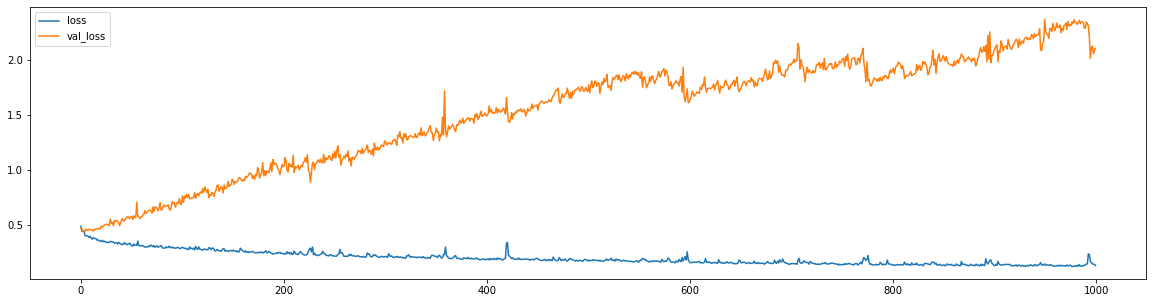

In [350]:
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [351]:
def submission_output(answer):
    submission_df['Survived'] = answer
    submission_df.to_csv('submission.csv', index=False)
    !kaggle competitions submit -c titanic -f submission.csv -m ""

In [31]:
test_pred = model.predict(test_X)
answer_test = get_answer(test_pred)
submission_output(answer_test)

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 20.4kB/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.14kB/s]


### Logistic Regression

In [352]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression()

In [353]:
answer_train=lr.predict(X_test)
compare_test(answer_train,Y_test)

0.8097014925373134


In [34]:
answer_test = lr.predict(test_X)
submission_output(answer_test)

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.1kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 1.05kB/s]


### Decision Tree Classifier

In [354]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

DecisionTreeClassifier()

In [355]:
answer_train=dtc.predict(X_test)
compare_test(answer_train,Y_test)

0.7686567164179104


In [37]:
answer_test = dtc.predict(test_X)
submission_output(answer_test)

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.4kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 1.07kB/s]


### Random Forest Classifier

In [356]:
rd_clf = RandomForestClassifier(n_estimators=100, max_depth=5)
rd_clf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5)

In [357]:
answer_train=rd_clf.predict(X_test)
compare_test(answer_train,Y_test)

0.7985074626865671


In [40]:
answer_test = rd_clf.predict(test_X)
submission_output(answer_test)

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.2kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 862B/s]  


### Random Forest Classifier with GridSearchCV

In [364]:
rd_clf2 = RandomForestClassifier()
hyper_parameter = {
    'n_estimators':[100, 150, 200, 250, 300, 350, 400],
    'max_depth':[5,8,10,12,15,20]
}

hyper_parameter_tuner = GridSearchCV(estimator=rd_clf2, param_grid=hyper_parameter, cv= 5)
hyper_parameter_tuner.fit(X_train, Y_train)
params = hyper_parameter_tuner.best_params_

In [365]:
rd_clf2 = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
rd_clf2.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, n_estimators=200)

In [366]:
answer_train=rd_clf.predict(X_test)
compare_test(answer_train,Y_test)

0.7985074626865671


In [ ]:
answer_test = rd_clf.predict(test_X)
submission_output(answer_test)

### Gradient Boosting Classifier

In [367]:
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)

GradientBoostingClassifier()

In [368]:
answer_train=gb.predict(X_test)
compare_test(answer_train,Y_test)

0.8134328358208955


In [369]:
answer_test = gb.predict(test_X)
submission_output(answer_test)

400 - Bad Request



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 20.7kB/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.32kB/s]


### XGB Classifier

In [360]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [361]:
answer_train=xgb.predict(X_test)
compare_test(answer_train,Y_test)

0.7873134328358209


In [46]:
answer_test = xgb.predict(test_X)
submission_output(answer_test)

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 22.5kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 827B/s]  


### Ensemble with previous Models

In [362]:
ensemble = pd.DataFrame([lr.predict(test_X), dtc.predict(test_X), rd_clf.predict(test_X), gb.predict(test_X), xgb.predict(test_X)]).T
ensemble.columns = ['lr', 'dtc', 'rd_clf', 'gb', 'xgb']
ensemble

ensemble['result'] = ensemble.sum(axis=1) > 2
to_binary = {False : 0, True : 1}
ensemble['result'].replace(to_binary, inplace=True)
ensemble

,lr,dtc,rd_clf,gb,xgb,result
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,0,0,0
4,1,0,1,0,1,1
...,...,...,...,...,...,...
413,0,0,0,0,0,0
414,1,1,1,1,1,1
415,0,0,0,0,0,0
416,0,0,0,0,0,0


In [74]:
submission_output(ensemble['result'])

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 23.8kB/s]
100%|##########| 3.18k/3.18k [00:03<00:00, 1.03kB/s]
